# Домашнее задание 19: Анализ временного ряда

## Импорт библиотек
В этом блоке подключаем библиотеки для анализа временных рядов.

In [22]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error
plt.style.use("seaborn-v0_8-whitegrid")

## Загрузка данных и выбор временного ряда пассажиропотока
Читаем продажи, выбираем товар с наибольшим совокупным спросом и агрегируем месячные продажи.

In [23]:
dataset = sm.datasets.get_rdataset('AirPassengers', 'datasets')
air_df = dataset.data.copy()
start = pd.Timestamp('1949-01-01')
monthly_index = pd.date_range(start=start, periods=len(air_df), freq='MS')
monthly_passengers = pd.Series(air_df['value'].values, index=monthly_index, name='passengers')
monthly_passengers = monthly_passengers.asfreq('MS')
print('Пассажиропоток из Rdatasets (месячный, 1949-1960).')
monthly_passengers.head()


Пассажиропоток из Rdatasets (месячный, 1949-1960).


1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Freq: MS, Name: passengers, dtype: int64

## Визуализация исходного ряда
Строим график месячного спроса, чтобы оценить тренды и сезонность.

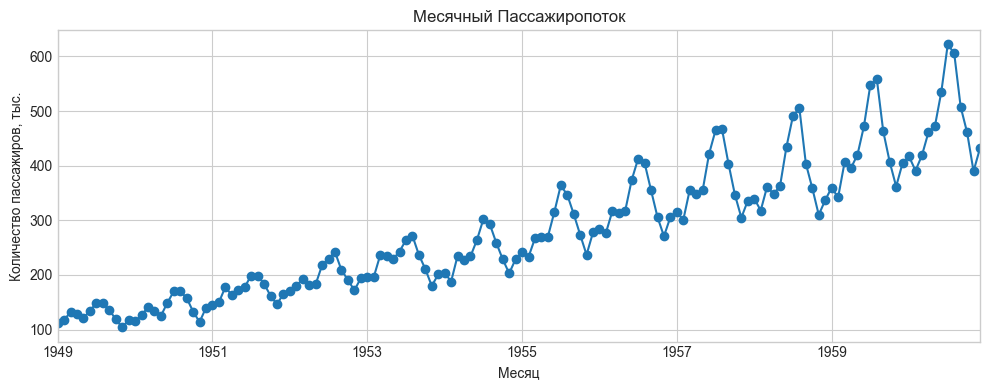

In [24]:
fig, ax = plt.subplots(figsize=(10, 4))
monthly_passengers.plot(ax=ax, marker='o')
ax.set_title('Месячный Пассажиропоток')
ax.set_ylabel('Количество пассажиров, тыс.')
ax.set_xlabel('Месяц')
plt.tight_layout()
plt.show()

## Первые разности и визуальная проверка стационарности
Считаем первые разности и сравниваем графики.

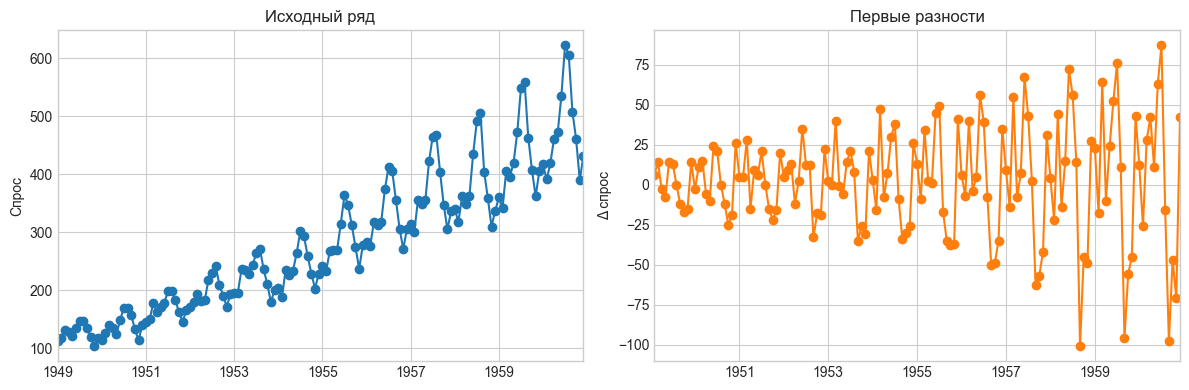

In [25]:
first_diff = monthly_passengers.diff().dropna()
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False)
monthly_passengers.plot(ax=axes[0], marker='o')
axes[0].set_title('Исходный ряд')
axes[0].set_ylabel('Спрос')
first_diff.plot(ax=axes[1], marker='o', color='tab:orange')
axes[1].set_title('Первые разности')
axes[1].set_ylabel('Δ спрос')
plt.tight_layout()
plt.show()

## Декомпозиция временного ряда
Разделяем ряд на тренд, сезонность и остаток.

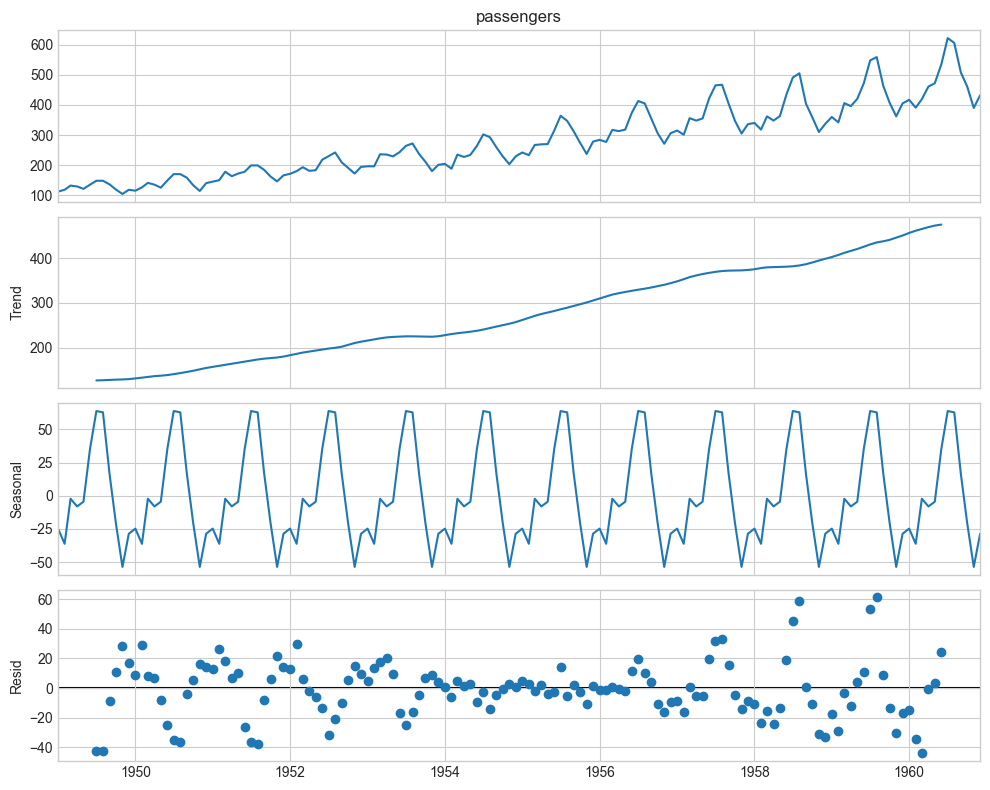

In [26]:
decomposition = seasonal_decompose(monthly_passengers, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

## Тест Дики — Фуллера
Проверяем стационарность исходного ряда и первых разностей.

In [29]:
def adf_report(series, name):
    stat, pvalue, _, _, critical_values, _ = adfuller(series)
    print(f'ADF-тест для {name}. Нулевая гипотеза (H₀) теста ADF: временной ряд нестационарен.')
    print(f'  Статистика: {stat:.3f}')
    print(f'  p-value: {pvalue:.4f}')
    for key, value in critical_values.items():
        print(f'  Критическое значение {key}: {value:.3f}')
    print()
adf_report(monthly_passengers, 'исходного ряда')
adf_report(first_diff, 'первых разностей')

ADF-тест для исходного ряда. Нулевая гипотеза (H₀) теста ADF: временной ряд нестационарен.
  Статистика: 0.815
  p-value: 0.9919
  Критическое значение 1%: -3.482
  Критическое значение 5%: -2.884
  Критическое значение 10%: -2.579

ADF-тест для первых разностей. Нулевая гипотеза (H₀) теста ADF: временной ряд нестационарен.
  Статистика: -2.829
  p-value: 0.0542
  Критическое значение 1%: -3.482
  Критическое значение 5%: -2.884
  Критическое значение 10%: -2.579



### Вывод: Исходные данные очевидно нестационарны (р-значение близко к 100%), но и приращения не без труда проходят 5%-барьер нулевой гипотезы о нестационарности, так как на графике видна гетероскедастичность, которую нельзя убрать вычитанием тренда и сезонности.

## ACF и PACF
Строим коррелограммы для подбора параметров ARIMA.

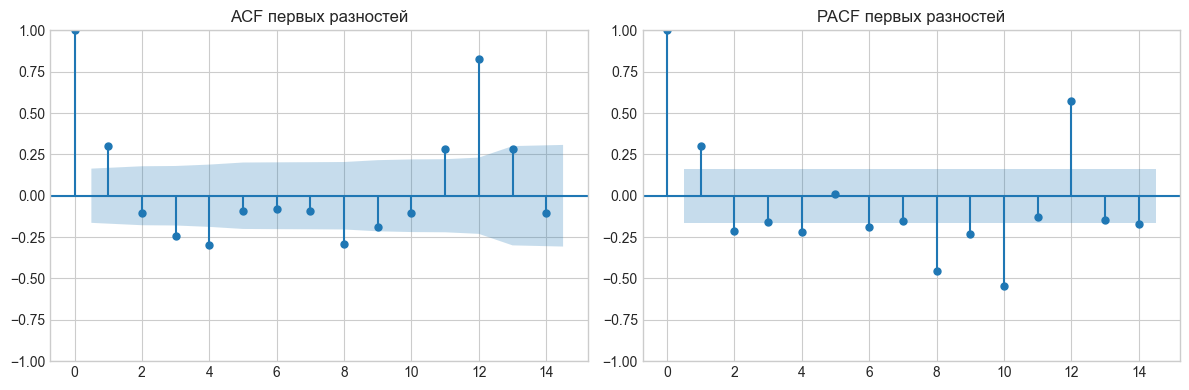

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(first_diff, lags=14, ax=axes[0])
plot_pacf(first_diff, lags=14, ax=axes[1], method='ywm')
axes[0].set_title('ACF первых разностей')
axes[1].set_title('PACF первых разностей')
plt.tight_layout()
plt.show()

### Вывод: Так ACF и PACF для 12го лага значимо (годичная сезонность), то AR-компонент модели должен быть длинной как минимум 12 лагов.

## Разделение на обучающую и тестовую выборки
Оставляем 10 последних наблюдений для проверки прогноза.

In [31]:
train = monthly_passengers.iloc[:-10]
test = monthly_passengers.iloc[-10:]
print(f'Размер обучающей выборки: {len(train)} точек')
print(f'Размер тестовой выборки: {len(test)} точек')
train.tail()

Размер обучающей выборки: 134 точек
Размер тестовой выборки: 10 точек


1959-10-01    407
1959-11-01    362
1959-12-01    405
1960-01-01    417
1960-02-01    391
Freq: MS, Name: passengers, dtype: int64

## Обучение модели ARIMA и прогноз
Обучаем простую модель ARMA(12, 1) = ARIMA(12,0,1) и строим прогноз на 10 периодов.

In [38]:
model = ARIMA(train, order=(12, 0, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index

f:\Staff\Иннополис\Innopolis\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
f:\Staff\Иннополис\Innopolis\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


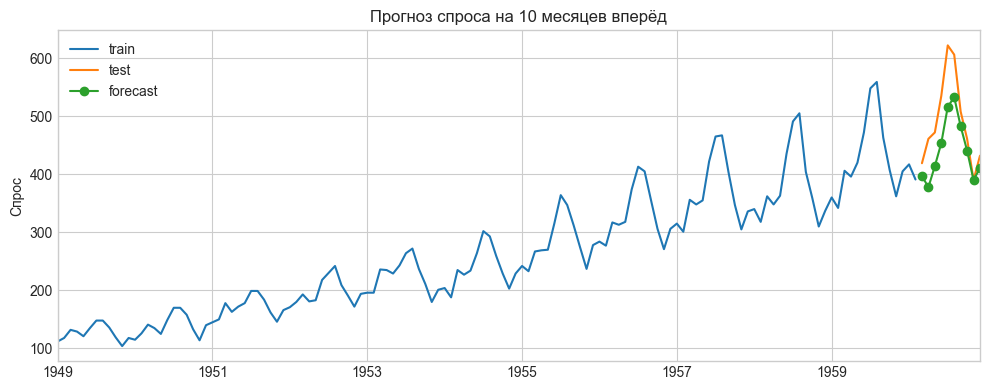

In [41]:
fig, ax = plt.subplots(figsize=(10, 4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
forecast.plot(ax=ax, label='forecast', marker='o')
ax.set_title('Прогноз спроса на 10 месяцев вперёд')
ax.set_ylabel('Спрос')
ax.legend()
plt.tight_layout()
plt.show()

Модель не учла тренд, обучаем модель ARIMA(12,1,1) и строим прогноз на 10 периодов.

f:\Staff\Иннополис\Innopolis\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
f:\Staff\Иннополис\Innopolis\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


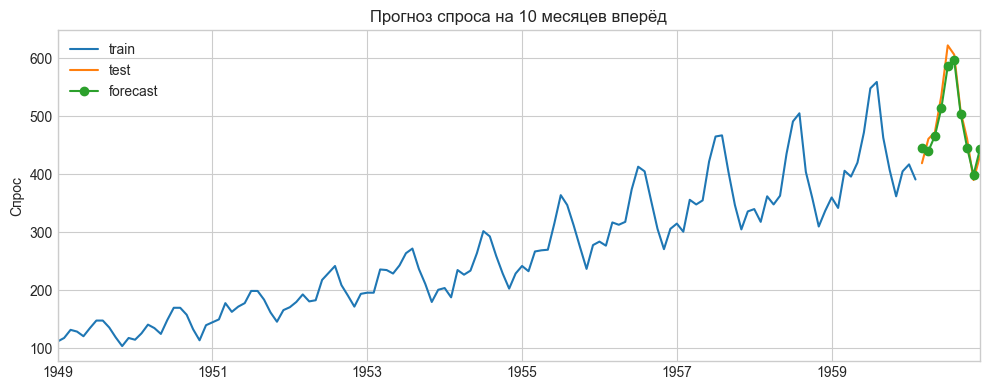

In [42]:
model = ARIMA(train, order=(12, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index

fig, ax = plt.subplots(figsize=(10, 4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
forecast.plot(ax=ax, label='forecast', marker='o')
ax.set_title('Прогноз спроса на 10 месяцев вперёд')
ax.set_ylabel('Спрос')
ax.legend()
plt.tight_layout()
plt.show()

### Вывод: Модель успешно продлила тренд и сезонность на год, но недооценила пиковое значение, так как наблюдается увеличение сезонного разброса значений (гетероскедастичность).

## Оценка качества прогноза
Считаем метрики R-squared, MAPE и RMSE.

In [43]:
def mean_absolute_percentage_error(y_true, y_pred):
    denom = np.where(y_true == 0, 1e-8, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100
r2 = r2_score(test, forecast)
rmse = mean_squared_error(test, forecast) ** 0.5
mape = mean_absolute_percentage_error(test.values, forecast.values)
print(f'R-squared: {r2:.3f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
comparison = pd.DataFrame({'actual': test, 'forecast': forecast})
comparison

R-squared: 0.935
RMSE: 18.74
MAPE: 3.26%


,actual,forecast
1960-03-01,419,445.624742
1960-04-01,461,440.086025
1960-05-01,472,465.825274
1960-06-01,535,513.289964
1960-07-01,622,585.880079
1960-08-01,606,596.281108
1960-09-01,508,504.522265
1960-10-01,461,445.759699
1960-11-01,390,399.136208
1960-12-01,432,443.412642


### Вывод: Показатели качества выглядят хорошо -- относительная ошибка по модулю порядка 3%. R2 очень высокий -- модель обяснила большую часть вариации в данных.